# 🏨Hotel Booking Analysis 👨‍👩‍👧🌠

## Background of Dataset

This dataset contains detailed booking information for two hotels located in Portugal: a Resort Hotel and a City Hotel.<br>
The data was originally collected from the hotels’ Property Management System (PMS) SQL databases, capturing real-world booking records over several years.<br>
<br>
The dataset includes a wide variety of attributes such as:<br>
<br>
-Booking dates and lead time<br>
-Guest demographics (e.g., number of adults, children, repeated guests, country)<br>
-Room preferences and assignment<br>
-Distribution channels and market segments<br>
-Special requests, cancellations, and parking space requirement<br>
-Financial data such as ADR (Average Daily Rate)<br>
<br>
With over 100,000 rows, this dataset provides a rich source for exploratory data analysis (EDA),<br>
pattern discovery, and predictive modeling related to hotel booking behavior.<br>
<br>
This makes it especially valuable for:<br>
<br>
-Understanding booking trends<br>
-Identifying factors that influence cancellations<br>
-Segmenting customer behavior<br>
-Improving hotel revenue management and marketing strategies<br>
<br>
<br>
**Reference :**<br>
*The data is originally written by Nuno Antonio, Ana Almeida, and Luis Nunes for Data in Brief, Volume 22, February 2019.*<br>
*The data was downloaded and cleaned by Thomas Mock and Antoine Bichat.*<br>
Article : https://www.sciencedirect.com/science/article/pii/S2352340918315191<br>
Variable Descriptions : https://www.sciencedirect.com/science/article/pii/S2352340918315191#sp0020

## Questions

1.Which room types are most popular for City Hotels versus Resort Hotels?<br>
2.What is the overall typical Average Daily Rate (ADR) for bookings in this dataset?<br>
3.How does the ADR for the same room type differ between City Hotels and Resort Hotels?<br>
4.How have booking trends evolved over time for each hotel type?<br>
5.When do City Hotels and Resort Hotels experience their highest and lowest Average Daily Rates throughout the year?<br>
6.Which countries are the primary sources of bookings for these hotels?<br>
7.Do bookings from certain countries typically yield a higher or lower ADR for the hotels?<br>
8.Do guests who pay a higher ADR tend to make more (or fewer) special requests?<br>
9.Does the ADR increase or decrease with a higher number of guests per booking?<br>
10.Are larger families (more family members) more likely to request a parking space?<br>
11.How does the booking lead time affect the likelihood of a booking being canceled?<br>
12.Which room type attracts more repeated guests?<br>
13.Which market segments are most dominant for City Hotels versus Resort Hotels?<br>
14.Which distribution channels are the most effective in generating bookings for each hotel type?<br>
15.What is the prevalence of different deposit types (e.g., No Deposit, Non-Refundable) for each hotel type?<br>
16.Are there any customer types that show surprisingly high or low booking volumes?


In [1]:
pip install pingouin --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 7.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import pingouin
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 🧹Data Pre-processing🧼✨

In [3]:
df = pd.read_csv("/kaggle/input/hotel-bookings/hotel_bookings.csv")
print(df.columns, df.shape)
df.isnull().sum()

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object') (119390, 32)


hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

Column Descriptions : https://www.sciencedirect.com/science/article/pii/S2352340918315191#sp0020<br>
<br>
Let's dive in each column that contains null value.<br>
<br>
For '**children**' and '**country**', null value for these columns are make sense to be removed.<br>
Since we got 119390 rows in total and null value in these columns are only 492 rows, I decide to remove it.<br>
For '**agent**' and '**company**', I decide to create new column **'book_by'** to identify who is booker,<br>
then remove agent and company column.

In [4]:
df = df[~((df['children'].isnull()) | (df['country'].isnull()))]
df['book_by'] = np.where(df['agent'].notnull(), 'Agent', np.where(df['company'].notnull(), 'Company', 'Private'))
df.drop(['agent', 'company'], axis=1, inplace=True)
df.shape


(118898, 31)

From observing, there are some rows of '**adr**' which contain value <= 0 and '**reservation_status**' = 'Check-Out'. <br>
This doesn't make sense because hotels should earn some money if customers check-out.<br>
Therefore, I decide to drop these rows as well.<br>

In [5]:
df = df[~((df['adr'] <= 0) & (df['reservation_status'] == 'Check-Out'))]
df.shape

(117162, 31)

To analyze ADR, I think we should focus on bookings which is not outliers of ADR and final status is not 'cancelled'

In [6]:
Q1 = df['adr'].quantile(0.25)
Q3 = df['adr'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#get only bookings that adr is not outliers and have actual guest 
df_focus = df[(df['adr'] > lower_bound) & (df['adr'] < upper_bound)]
df_adr_cleaned = df_focus[df_focus['is_canceled'] == 0].copy()

#From now on, I will use only df_adr_cleaned when working with ADR. 

# 📊Summary Statistics

In [7]:
df_adr_cleaned.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,70476.0,70476.000000,70476.000000,70476.000000,70476.000000,70476.000000,70476.000000,70476.000000,70476.000000,70476.000000,70476.000000,70476.000000,70476.000000,70476.000000,70476.000000,70476.000000,70476.000000,70476.000000
mean,0.0,82.091251,2016.143155,26.900065,15.827870,0.940107,2.483299,1.829573,0.082553,0.009649,0.038197,0.014601,0.183807,0.282181,1.647994,97.504608,0.094387,0.703771
std,0.0,91.982169,0.701296,14.005070,8.781538,0.984349,1.890576,0.497486,0.343876,0.110045,0.191674,0.269167,1.766236,0.704672,15.133564,38.982267,0.296656,0.822964
min,0.0,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.260000,0.000000,0.000000
25%,0.0,10.000000,2016.000000,15.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68.750000,0.000000,0.000000
50%,0.0,48.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,92.000000,0.000000,1.000000
75%,0.0,128.000000,2017.000000,39.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,121.330000,0.000000,1.000000
max,0.0,709.000000,2017.000000,53.000000,31.000000,16.000000,41.000000,4.000000,3.000000,10.000000,1.000000,13.000000,72.000000,18.000000,379.000000,208.860000,8.000000,5.000000


In [8]:
df_adr_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70476 entries, 2 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           70476 non-null  object 
 1   is_canceled                     70476 non-null  int64  
 2   lead_time                       70476 non-null  int64  
 3   arrival_date_year               70476 non-null  int64  
 4   arrival_date_month              70476 non-null  object 
 5   arrival_date_week_number        70476 non-null  int64  
 6   arrival_date_day_of_month       70476 non-null  int64  
 7   stays_in_weekend_nights         70476 non-null  int64  
 8   stays_in_week_nights            70476 non-null  int64  
 9   adults                          70476 non-null  int64  
 10  children                        70476 non-null  float64
 11  babies                          70476 non-null  int64  
 12  meal                            7047

# 🔍Exploratory Data Analysis (EDA)📈




## 1.Number of Bookings by Hotel Type and Room Type

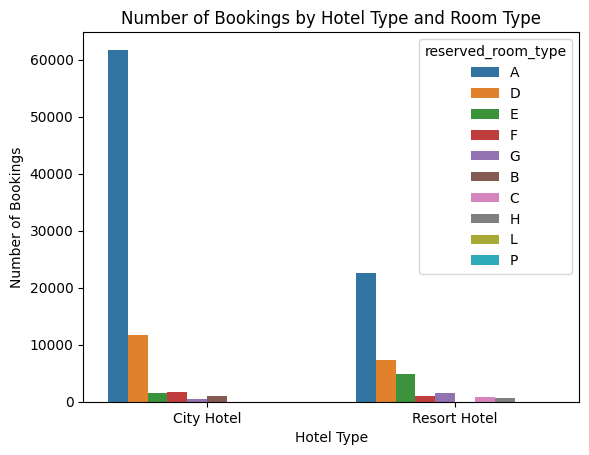

In [9]:
booking_counts = df[['hotel', 'reserved_room_type']].value_counts().reset_index()
booking_counts.columns = ['hotel','reserved_room_type','number_of_bookings']
 
sns.barplot(data=booking_counts, x='hotel', y='number_of_bookings', hue='reserved_room_type')
plt.title('Number of Bookings by Hotel Type and Room Type')
plt.ylabel('Number of Bookings')
plt.xlabel('Hotel Type')
plt.show()

City Hotel has a higher number of bookings than Resort Hotel.<br>
The most common room type is **'A'**, and its quantity is significantly higher than the second most popular type.

## 2.ADR Distribution

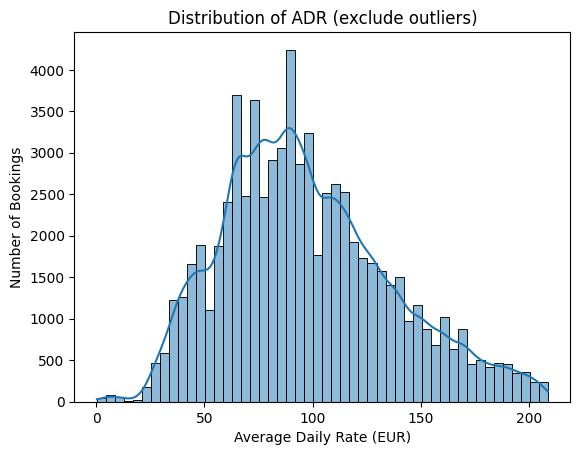

In [10]:
sns.histplot(data=df_adr_cleaned, x='adr', bins=50, kde=True)

plt.title('Distribution of ADR (exclude outliers)')
plt.xlabel('Average Daily Rate (EUR)')
plt.ylabel('Number of Bookings')
plt.show()

## 3.ADR Distribution by Reserved Room Type and Hotel Type

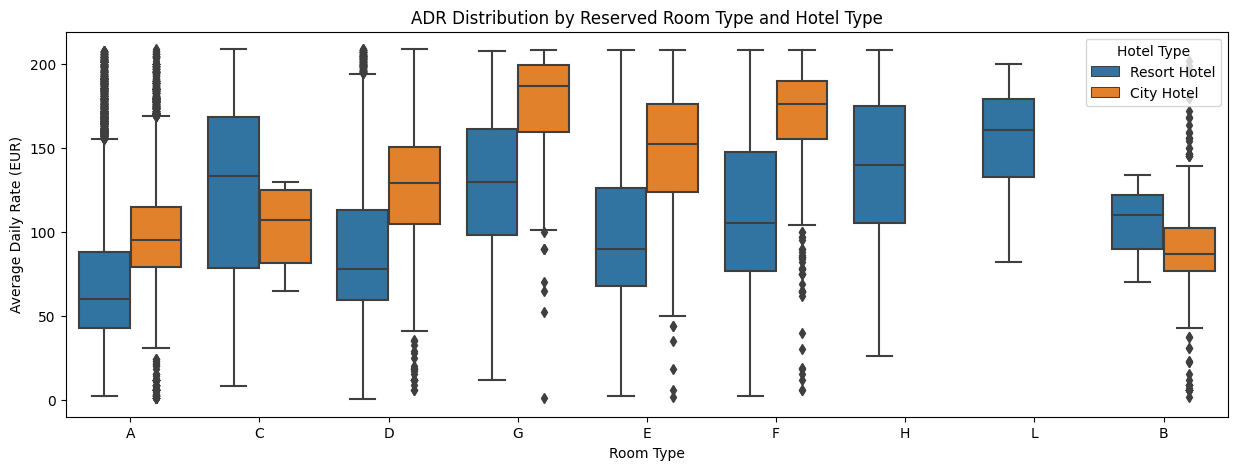

In [11]:
plt.figure(figsize = (15,5))

sns.boxplot(data=df_adr_cleaned, x='reserved_room_type', y='adr', hue='hotel')

plt.title('ADR Distribution by Reserved Room Type and Hotel Type')
plt.xlabel('Room Type')
plt.ylabel('Average Daily Rate (EUR)')
plt.legend(title='Hotel Type')
plt.show()

From overall distribution, **City hotel** tend to have higher average ADR than **Resort hotel**.<br>
Room **P** type seems to be dummy room for system test.<br>
Room **L** type is valid for only Resort hotel.<br>

## 4.Number of Bookings Overtime by Hotel Type

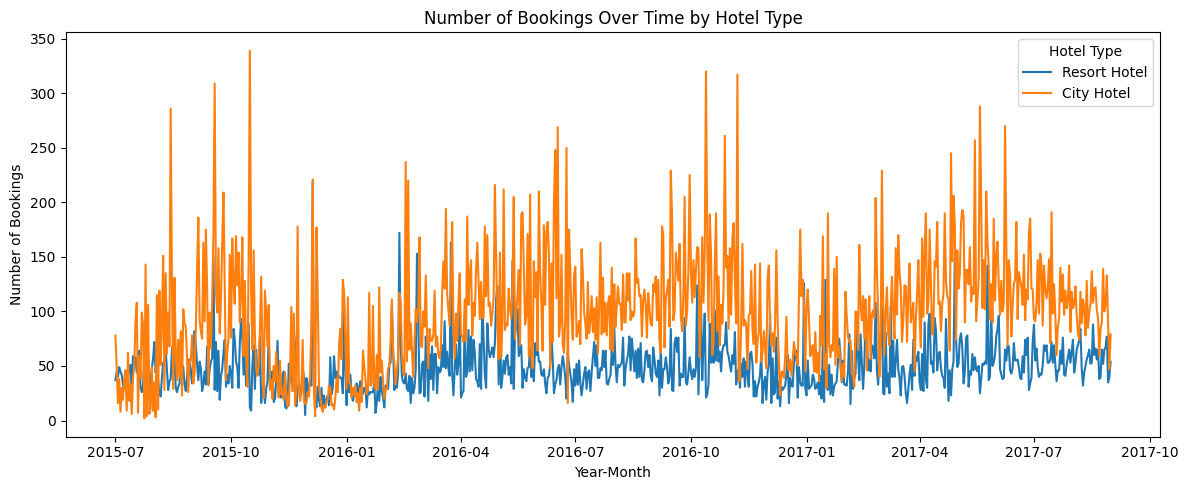

In [12]:
df['arrival_date_year'] = df['arrival_date_year'].astype(str)
df['arrival_date_day_of_month'] = df['arrival_date_day_of_month'].astype(str)
df['arrival_date'] = df['arrival_date_day_of_month'] + df['arrival_date_month'] + df['arrival_date_year']
df['arrival_date'] = pd.to_datetime(df['arrival_date'])
booking_counts = df[['hotel', 'arrival_date']].value_counts().reset_index()
booking_counts.columns = ['hotel','arrival_date','number_of_bookings']

plt.figure(figsize=(12, 5))
sns.lineplot(data=booking_counts, x='arrival_date', y='number_of_bookings', hue='hotel', hue_order=['Resort Hotel', 'City Hotel'])

plt.title('Number of Bookings Over Time by Hotel Type')
plt.xlabel('Year-Month')
plt.ylabel('Number of Bookings')
plt.legend(title='Hotel Type')
plt.tight_layout()
plt.show()

Across the entire period, **City Hotels** generally record a higher volume of bookings compared to **Resort Hotels**.

## 5.Seasonal ADR by Hotel Type

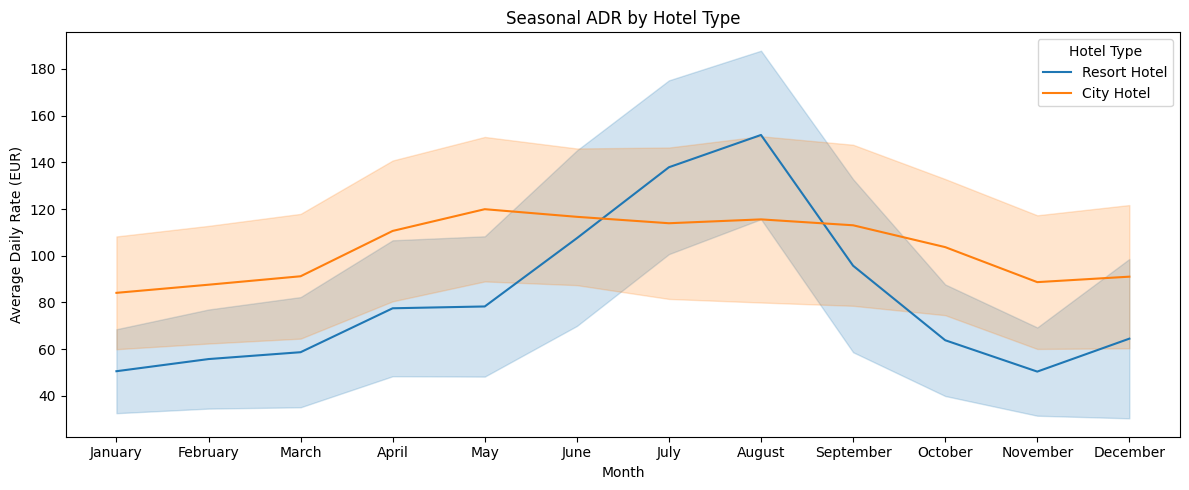

In [13]:
ordered_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
df_adr_cleaned["arrival_date_month"] = pd.Categorical(df_adr_cleaned["arrival_date_month"], categories=ordered_months, ordered=True)

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_adr_cleaned, x='arrival_date_month', y='adr', hue='hotel', ci='sd')

plt.title('Seasonal ADR by Hotel Type')
plt.xlabel('Month')
plt.ylabel('Average Daily Rate (EUR)')
plt.legend(title='Hotel Type')
plt.tight_layout()
plt.show()

July and August represent the peak season for **Resort Hotels**, leading to a significant surge in prices,<br> 
whereas **City Hotels** observe a more modest price increase during this period.
 

## 6.Number of bookings by Country

In [14]:
booking_counts = df[['hotel', 'country']].value_counts().reset_index()
booking_counts.columns = ['hotel','country','number_of_bookings']

world_bookings = px.choropleth(booking_counts,
                          locations='country',
                          color='number_of_bookings',
                          hover_name='country',
                          color_continuous_scale=px.colors.sequential.matter,
                          labels={'number_of_bookings':'Number of bookings'})

world_bookings.update_layout(coloraxis_showscale=True,)

world_bookings.show(renderer="iframe_connected")

Given that this dataset was collected from hotels in Portugal,<br> 
it is not surprising that the majority of bookings originated from within Portugal.

## 7.Average Daily Rate (ADR) by Country


In [15]:
world_adr = px.choropleth(df_adr_cleaned,
                          locations='country',
                          color='adr',
                          hover_name='country',
                          color_continuous_scale=px.colors.sequential.matter,
                          labels={'adr':'Average Daily Rate'})

world_adr.update_layout(coloraxis_showscale=True,)

world_adr.show(renderer="iframe_connected")

Although the majority of bookings originated from within Portugal,<br>
the highest average daily rate (ADR) was achieved by another country.

## 8.Impact of Average Daily Rate (ADR) on Special Requests

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight

/tmp/ipykernel_13/1715713768.py:32: UserWarning:

The figure layout has changed to tight



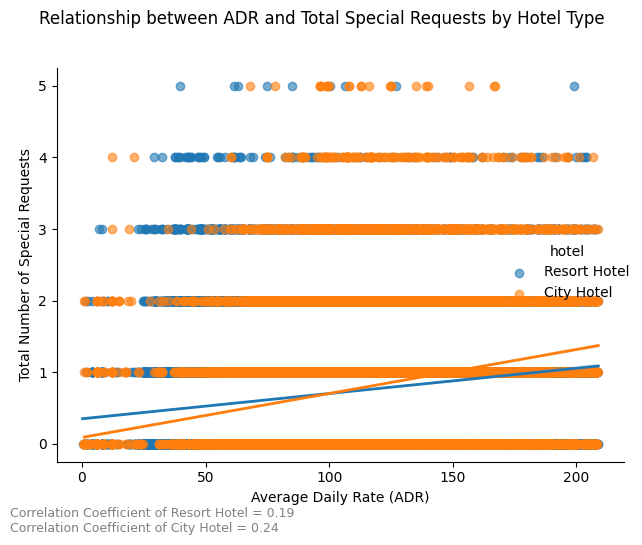

In [16]:
corr_resort = np.corrcoef(
    df_adr_cleaned[df_adr_cleaned['hotel'] == 'Resort Hotel']['adr'], 
    df_adr_cleaned[df_adr_cleaned['hotel'] == 'Resort Hotel']['total_of_special_requests']
)[0,1]
corr_city = np.corrcoef(
    df_adr_cleaned[df_adr_cleaned['hotel'] == 'City Hotel']['adr'], 
    df_adr_cleaned[df_adr_cleaned['hotel'] == 'City Hotel']['total_of_special_requests']
)[0,1]

g = sns.lmplot(
    data=df_adr_cleaned,
    x='adr',
    y='total_of_special_requests',
    hue='hotel',
    ci=95,
    scatter_kws={'alpha':0.6},
    line_kws={'lw':2}
)

g.set_axis_labels("Average Daily Rate (ADR)","Total Number of Special Requests")
g.set_titles("Relationship between ADR and Total Special Requests by Hotel Type")
g.fig.text(
    x=0.01,
    y=-0.03,
    s=f'Correlation Coefficient of Resort Hotel = {round(corr_resort, 2)} \nCorrelation Coefficient of City Hotel = {round(corr_city, 2)}',
    fontsize=9,
    color='grey',
    ha='left',
    va='bottom'
)
plt.suptitle("Relationship between ADR and Total Special Requests by Hotel Type", y=1.02)
plt.tight_layout()
plt.show()

Correlation coefficient between **Average Daily Rate (ADR)** and **Total Number of Special Requests** between 2 hotel are 0.19, 0.24.<br>
The linear correlations are quite weak.
This means that as **Average Daily Rate (ADR)** increases, **Total Number of Special Requests** also tends to increase, but the relationship is not strong enough to be highly significant.

## 9.Influence of Number of Guests on Average Daily Rate (ADR)

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight

/tmp/ipykernel_13/1816856765.py:41: UserWarning:

The figure layout has changed to tight



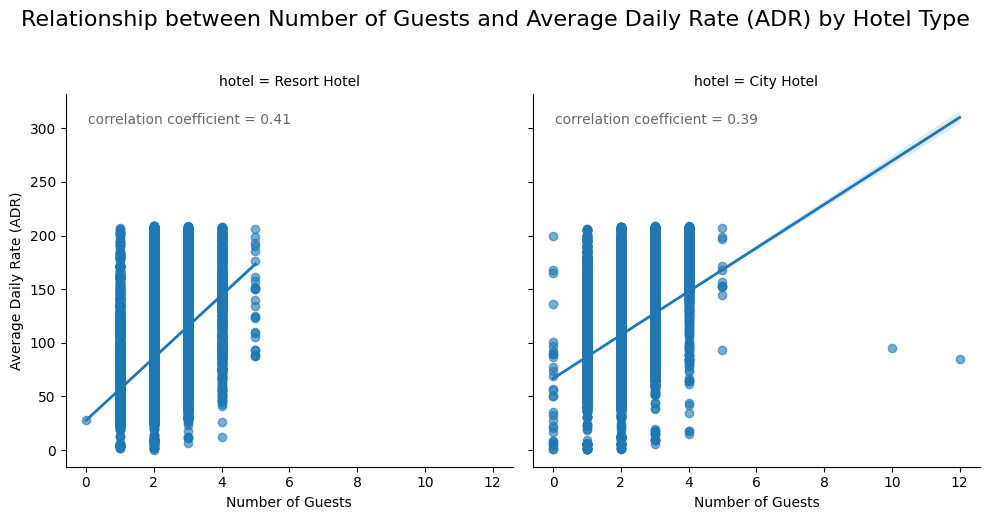

In [17]:
df_adr_cleaned['guest'] = df_adr_cleaned['adults'] + df_adr_cleaned['children'] + df_adr_cleaned['babies']
corr_resort = np.corrcoef(
    df_adr_cleaned[df_adr_cleaned['hotel'] == 'Resort Hotel']['guest'],
    df_adr_cleaned[df_adr_cleaned['hotel'] == 'Resort Hotel']['adr']
)[0, 1]

corr_city = np.corrcoef(
    df_adr_cleaned[df_adr_cleaned['hotel'] == 'City Hotel']['guest'],
    df_adr_cleaned[df_adr_cleaned['hotel'] == 'City Hotel']['adr']
)[0, 1]

g = sns.lmplot(
    data=df_adr_cleaned,
    x='guest',
    y='adr',
    col='hotel',
    col_order=['Resort Hotel', 'City Hotel'],
    ci=95,
    scatter_kws={'alpha':0.6},
    line_kws={'lw':2}
)
g.set_axis_labels("Number of Guests","Average Daily Rate (ADR)")

for ax, hotel_type in zip(g.axes.flat, g.col_names):
    if hotel_type == 'Resort Hotel':
        correlation_val = corr_resort
    else: # 'City Hotel'
        correlation_val = corr_city

    ax.text(
        x=0.05,
        y=0.95,
        s=f'correlation coefficient = {correlation_val:.2f}',
        fontsize=10,
        color='dimgray',
        ha='left',
        va='top',
        transform=ax.transAxes
    )
plt.suptitle("Relationship between Number of Guests and Average Daily Rate (ADR) by Hotel Type", y=1.03, fontsize=16)
plt.tight_layout()
plt.show()

The correlation between **ADR** and **Number of Family Members** are 0.41 and 0.39.<br>
As the Total Number of Family Members increases, the Average Daily Rate (ADR) also exhibits a tendency to rise, though the strength of this relationship is moderate.

## 10.Relationship between Number of Family Members and Parking Space Request

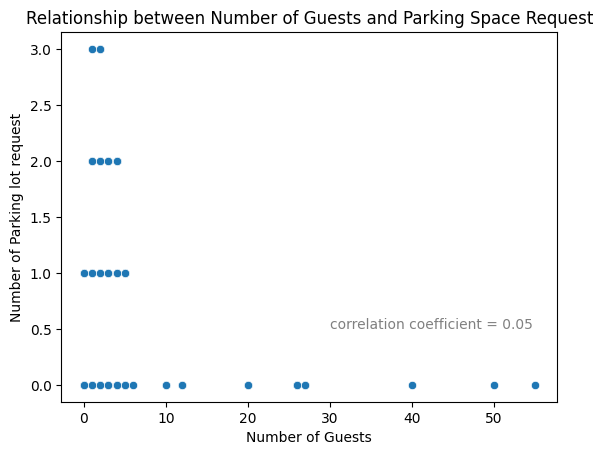

In [18]:
df['guest'] = df['adults'] + df['children'] + df['babies']
corr = np.corrcoef(df['guest'], df['required_car_parking_spaces'])

sns.scatterplot(
    data=df[df['required_car_parking_spaces'] != 8], #Exclude outliers
    x='guest',
    y='required_car_parking_spaces'
)

plt.title("Relationship between Number of Guests and Parking Space Request")
plt.text(30, 0.5, f"correlation coefficient = {round(corr[0,1],2)}", fontsize=10, color='gray')
plt.xlabel("Number of Guests")
plt.ylabel("Number of Parking lot request")
plt.show()

As the number of guests increases, it does not show a relationship with the number of parking lot requests.

## 11.Impact of Lead Time on Cancellation Rates

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight

/tmp/ipykernel_13/1786686254.py:27: UserWarning:

The figure layout has changed to tight



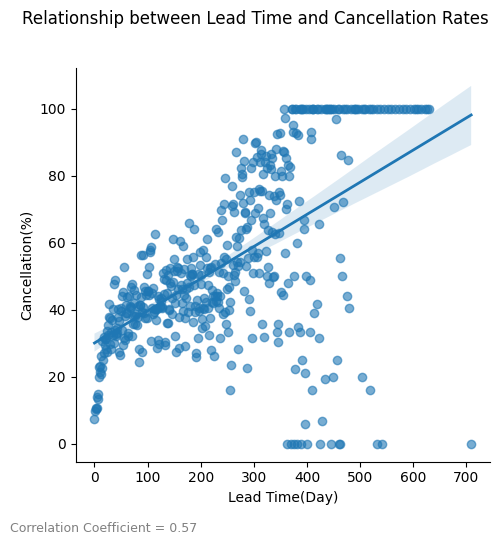

In [19]:
leadtime_cancelled = df.groupby("lead_time")["is_canceled"].mean().reset_index()
leadtime_cancelled.columns = ['lead_time', 'cancellation_mean']
leadtime_cancelled['%cancellation'] = leadtime_cancelled['cancellation_mean']*100 
corr = np.corrcoef(leadtime_cancelled['lead_time'], leadtime_cancelled['%cancellation'])

g = sns.lmplot(
    data=leadtime_cancelled,
    x='lead_time',
    y='%cancellation',
    ci=95,
    scatter_kws={'alpha':0.6},
    line_kws={'lw':2}
)

g.set_axis_labels("Lead Time(Day)","Cancellation(%)")
g.set_titles("Relationship between Lead Time and Cancellation Rates")
g.fig.text(
    x=0.01,
    y=-0.03,
    s=f'Correlation Coefficient = {round(corr[0][1], 2)}',
    fontsize=9,
    color='grey',
    ha='left',
    va='bottom'
)
plt.suptitle("Relationship between Lead Time and Cancellation Rates", y=1.02)
plt.tight_layout()
plt.show()

As the lead time (how far in advance a booking is made) increases,<br>
the likelihood of that booking being canceled also tends to rise.

## 12.Number of Bookings by Repeated Guests per Room Type and Hotel

In [20]:
df_repeated = df[df['is_repeated_guest'] == 1]
booking_counts = df_repeated[['hotel', 'reserved_room_type']].value_counts().reset_index()
booking_counts.columns = ['hotel','reserved_room_type','number_of_bookings']

fig = px.bar(
    booking_counts,
    x='reserved_room_type',
    y='number_of_bookings',
    color='hotel',
    barmode='group',
    title='Number of Bookings by Repeated Guests per Room Type and Hotel',
    labels={'reserved_room_type': 'Room Type', 'number_of_bookings': 'Number of Bookings'},
    category_orders={'hotel': ['Resort Hotel', 'City Hotel']}
)

fig.show(renderer="iframe_connected")

Since the most room type in this dataset is **A**, the most room type of repeated guests is **A** as well.
No suprising here.

## 13.Number of Bookings by Market Segment per Hotel

In [21]:
booking_counts = df[['hotel', 'market_segment']].value_counts().reset_index()
booking_counts.columns = ['hotel','market_segment','number_of_bookings']

fig = px.pie(
    booking_counts,
    names='market_segment',
    values='number_of_bookings',
    title='Number of Bookings by Market Segment per Hotel',
    facet_col='hotel',
    color_discrete_sequence=px.colors.qualitative.Set3,
    category_orders={'hotel': ['Resort Hotel', 'City Hotel']}
)

fig.show(renderer="iframe_connected")

The majority of bookings for both **City Hotel** and **Resort Hotel** come from the Online TA (Online Travel Agency) market segment.<br>
This segment refers to reservations made by individual travelers or tourists through online travel platforms such as Booking.com, Agoda, or Expedia.<br>
This suggests that the primary customers of both **City Hotel** and **Resort Hotel** are leisure travelers who prefer the convenience and accessibility of online booking services.

## 14.Number of Bookings by Distribution Channel per Hotel

In [22]:
booking_counts = df[['hotel', 'distribution_channel']].value_counts().reset_index()
booking_counts.columns = ['hotel','distribution_channel','number_of_bookings']

fig = px.pie(
    booking_counts,
    names='distribution_channel',
    values='number_of_bookings',
    title='Number of Bookings by distribution_channel per Hotel',
    facet_col='hotel',
    color_discrete_sequence=px.colors.qualitative.Set2,
    category_orders={'hotel': ['Resort Hotel', 'City Hotel']}
)

fig.show(renderer="iframe_connected")

Similar to the market segment analysis, <br> 
the majority of bookings for both City Hotel and Resort Hotel originate from Online Travel Agencies

## 15.Number of Bookings by Deposit Type per Hotel

In [23]:
booking_counts = df[['hotel', 'deposit_type']].value_counts().reset_index()
booking_counts.columns = ['hotel','deposit_type','number_of_bookings']

fig = px.pie(
    booking_counts,
    names='deposit_type',
    values='number_of_bookings',
    title='Number of Bookings by Deposit Type per Hotel',
    facet_col='hotel',
    color_discrete_sequence=px.colors.qualitative.D3,
    category_orders={'hotel': ['Resort Hotel', 'City Hotel']},
    hole=0.4
)

fig.show(renderer="iframe_connected")

Each hotel requires no deposit the most for bookings.

## 16.Number of Bookings by Customer Type

In [24]:
booking_counts = df[['hotel', 'book_by']].value_counts().reset_index()
booking_counts.columns = ['hotel','book_by','number_of_bookings']

fig = px.pie(
    booking_counts,
    names='book_by',
    values='number_of_bookings',
    title='Number of Bookings by Customer Type',
    facet_col='hotel',
    color_discrete_sequence=px.colors.qualitative.Plotly,
    category_orders={'hotel': ['Resort Hotel', 'City Hotel']},
    hole=0.4
)

fig.show(renderer="iframe_connected")

For both hotel types, more than 80% of bookings originate from agents,<br> 
encompassing both Online Travel Agencies and Traditional Travel Agencies.

# ⚖️Hypothesis Testing

### Cancellation rates between Resort Hotel and City Hotel

H0 (null hypothesis, p-val >= 0.05)         : Cancellation rates between Resort Hotel and City Hotel are independent.

HA (alternative hypothesis, p-val < 0.05)   : Cancellation rates between Resort Hotel and City Hotel are associated.

In [25]:
#Find Proportion of Cancellation rates
props = df.groupby('hotel')['is_canceled'].mean()
print(props)

hotel
City Hotel      0.422842
Resort Hotel    0.284471
Name: is_canceled, dtype: float64


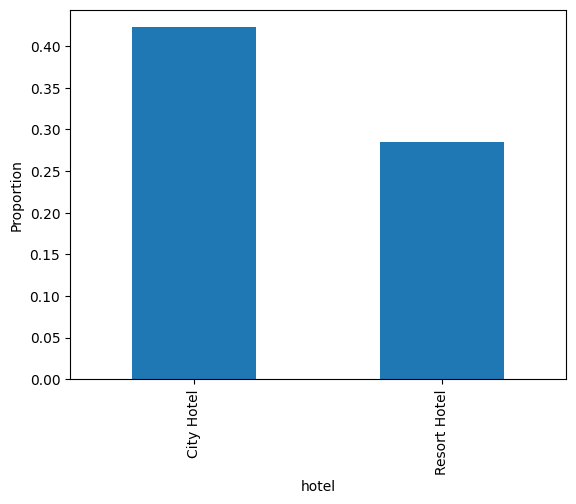

In [26]:
#Plot bar chart
props.plot(kind='bar', stacked=True)
plt.ylabel('Proportion')
plt.show()

In [27]:
# chi-square test compares proportions of successes of one categorical variable across the categories or another categorical variable.
# props table is for only showing proportion of cancellation rates. It can't be used in pingouin package.
# statistical package like pingouin need only raw data (df) to perform chi-square .
expected, observed, stats = pingouin.chi2_independence(data=df, x="hotel", y="is_canceled")
print(stats[stats['test'] == 'pearson']) 

      test  lambda         chi2  dof  pval    cramer  power
0  pearson     1.0  2119.063125  1.0   0.0  0.134486    1.0


p-val = 0.0<br>
Reject the null hypothesis and conclude that cancellation rates between Resort Hotel and City Hotel are associated.<br>
Hotel type is statistically significantly associated with cancellation rates.